# Piping Calculations

Import the fluids library.  Check the readme file here: http://fluids.readthedocs.io/index.html

In [1]:
import fluids

Import the thermo library.  Check the readme file here:  http://thermo.readthedocs.io/en/latest/

In [2]:
import thermo

Objective:  Sizing control valves for liquid services.  Basis for this problem is from Crane TP410.
Given:  250 gpm of condensate from a pressurized condensate tank is cooled from 225 F to 160 F in a heat exchanger then pupmped to a 50 psig pressuized header. Inlet and outlet pipe of the conrol valve is 4" schedule 40 with no valves or fittings within 5 feet of the valve.  The system is located in a facility at sea level.  A single port style valve is desired and the following table lists the valve sizes available and their corresponding Cv at 100% open.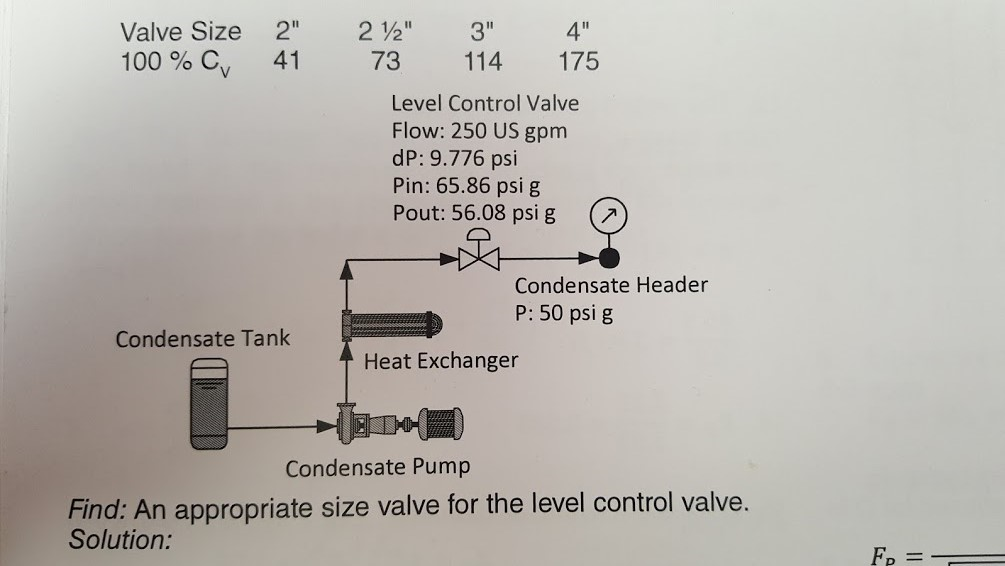


Get fluid property for water

Solution from Thermo 

In [43]:
from fluids.units import *
T = (160*u.degF).to(u.degK).magnitude

The fluid units interfers with scipy constants definitions for gallon, inch, minute, pressure, atm.  Need to do the temperature converstion with pint(build into fluids) before importing scipy.constants.

In [64]:
from scipy.constants import *
from fluids.control_valve import size_control_valve_l
from thermo.chemical import Chemical

P1 = 65.86*psi + atm # to Pa
P2 = 56.1*psi + atm # to Pa
water = Chemical('water', P=(P1+P2)/2, T=T)
rho = water.rho
Psat = water.Psat
Pc = water.Pc
mu = water.mu
Q = 250*gallon/minute # to m^3/s
D1 = D2 = 4*inch # to m
d = 3*inch # to m

Kv = size_control_valve_l(rho, Psat, Pc, mu, P1, P2, Q, D1, D2, d, FL=1, Fd=1)
Cv = 1.1560992283536566*Kv

print('Kv: {0:.2f}\nCv: {1:.2f}'.format(Kv, Cv))



Kv: 69.24
Cv: 80.05


Kv_to_Cv(2) returns an error.  Seems likely the Kv_to_Cv function is broken.  The conversion is a simple muliplication.


# Solution from Crane 410

Get chemical names from PubChem.  All calculatoins must be in SI units

In [ ]:

T = (160*u.degF).to(u.degK)
P1 = (65.86*u.psi + 14.7*u.psi).to(u.Pa)
P2 = (56.1*u.psi + 14.7*u.psi).to(u.Pa)
water = Chemical('water', P=((P1+P2)/2).magnitude , T=T.magnitude)
S = water.SG #specific gravity
rho = water.rho #density
mu = water.mu #viscosity
Psat = water.Psat #vapor pressue
Pc = water.Pc #critical pressure

System Properties

Need to convert the units all quantities to US units before using formulas from Crane 410

In [ ]:
Q = 250*u.gallon/u.minute
rho = (rho*u.kilogram/(u.meter**3)).to(u.lb/u.cubic_feet)
mu = mu*1000 #cP
Psat = (Psat*u.Pa).to(u.psi) #actually psia
Pc = (Pc*u.Pa).to(u.psi) #actually psia
P1 = (P1).to(u.psi) #actually psia)
P2 = (P2).to(u.psi) #actually psia)

Assume Fp=1.0 as a start, calculate Cv

In [ ]:
Fp = 1.0
deltaP = (P1 - P2).magnitude
Cv = Q.magnitude/(Fp*sqrt(deltaP/S))
Cv_desired = Cv

Initial valve selection:  Based on the above table, a 2-1/2" valve would be too small, a 3" valve should have the available capacity, and the 4" valve may be over-sized for the application.

Calculate piping gemometry factor for a fully open 3" valve with 4"x3" inlet and outlet reducers.

In [ ]:
dnumV = 3*u.inch
dnum = 4*u.inch

Ktot = 1.5*(1-(dnumV/dnum)**2)**2

In [ ]:
Cv = 114 #assuming using fully open 3" Cv
Fp = 1/sqrt(1+(Ktot/890)*(Cv/dnumV.magnitude**2)**2)

In [ ]:
Fp

Effective Cv is defined to be Fp*Cv which here means the fully open Cv of the valve accounting for fittings.

In [ ]:
Cv_eff = Fp*Cv
Cv_eff

Recaulcuate Fp at the valve position close to the required Cv.

In [ ]:
Fp = 1/sqrt(1+(Ktot/890)*(Cv_desired/dnumV.magnitude**2)**2)

In [ ]:
Fp

Recalculate Cv to confirm that the selected vavle is adequately sized

In [ ]:
Cv_confirm = Q.magnitude/(Fp*sqrt(deltaP/S))

In [ ]:
Cv_confirm

Since Cv is less than the valves Cv at 100% open iwth atached fittings, the 3" control valve will have adequate capacity for the applicaition and will be throttled to a Cv=80.03 to contorl the flow at the desired rate.